In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

In [2]:
from time import time
import logging
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

# !pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 3023
dimensionality of images: (154, 154, 3)
number of unique classes (people): 62


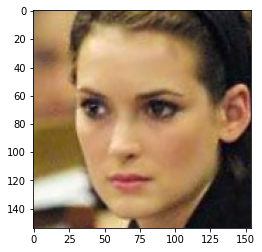

In [4]:
plt.imshow(X[0]/255)

Jean Chretien


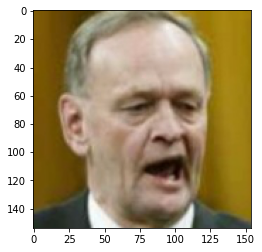

In [5]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i] / 255)
plt.grid(False)
print(target_names[y[i]])

In [6]:
# #Lets look at the data to see what they look like

# pl.figure
# for i in range(0,3):
#     pl.subplot(1,3,i+1)
#     pl.imshow(X[i].reshape((h,w)), cmap=pl.cm.bone)
#     pl.title(target_names[lfw_people.target[i]])
#     pl.xticks(())
#     pl.yticks(())

In [7]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [8]:
class Dropblock(tf.keras.layers.Layer):
  """DropBlock: a regularization method for convolutional neural networks.
    DropBlock is a form of structured dropout, where units in a contiguous
    region of a feature map are dropped together. DropBlock works better than
    dropout on convolutional layers due to the fact that activation units in
    convolutional layers are spatially correlated.
    See https://arxiv.org/pdf/1810.12890.pdf for details.
  """
  def __init__(self,
               dropblock_keep_prob=0.9,
               dropblock_size=5,
               data_format='channels_last'):
    super(Dropblock, self).__init__()
    self._dropblock_keep_prob = dropblock_keep_prob
    self._dropblock_size = dropblock_size
    self._data_format = data_format

  def call(self, net, training=False):
    """Builds Dropblock layer.
    Args:
      net: `Tensor` input tensor.
      is_training: `bool` if True, the model is in training mode.
    Returns:
      A version of input tensor with DropBlock applied.
    """
    if (not training or self._dropblock_keep_prob is None or
        self._dropblock_keep_prob == 1.0):
      return net

  

    if self._data_format == 'channels_last':
      height = tf.shape(net)[1]
      width = tf.shape(net)[2]
      #_, height, width, _ = net.get_shape().as_list()
    else:
      height = tf.shape(net)[2]
      width = tf.shape(net)[3]
      #_, _, height, width = net.get_shape().as_list()

    total_size = width * height
    dropblock_size = tf.math.minimum(self._dropblock_size, tf.math.minimum(width, height))
    # Seed_drop_rate is the gamma parameter of DropBlcok.
    seed_drop_rate = (
        1.0 - self._dropblock_keep_prob) * tf.cast(total_size, tf.float32) / tf.cast(dropblock_size**2 , tf.float32) / tf.cast(
            (width - self._dropblock_size + 1) *
            (height - self._dropblock_size + 1), tf.float32)

    # Forces the block to be inside the feature map.
    w_i, h_i = tf.meshgrid(tf.range(width), tf.range(height))
    valid_block = tf.logical_and(
        tf.logical_and(w_i >= tf.cast(dropblock_size / 2, tf.int32),
                       w_i < width - (dropblock_size - 1) // 2),
        tf.logical_and(h_i >= tf.cast(dropblock_size / 2, tf.int32),
                       h_i < width - (dropblock_size - 1) // 2))

    if self._data_format == 'channels_last':
      valid_block = tf.reshape(valid_block, [1, height, width, 1])
    else:
      valid_block = tf.reshape(valid_block, [1, 1, height, width])

    randnoise = tf.random.uniform(tf.shape(net), dtype=tf.float32)
    valid_block = tf.cast(valid_block, dtype=tf.float32)
    seed_keep_rate = tf.cast(1 - seed_drop_rate, dtype=tf.float32)
    block_pattern = (1 - valid_block + seed_keep_rate + randnoise) >= 1
    block_pattern = tf.cast(block_pattern, dtype=tf.float32)

    if self._data_format == 'channels_last':
      ksize = [1, self._dropblock_size, self._dropblock_size, 1]
    else:
      ksize = [1, 1, self._dropblock_size, self._dropblock_size]
    block_pattern = -tf.nn.max_pool(
        -block_pattern,
        ksize=ksize,
        strides=[1, 1, 1, 1],
        padding='SAME',
        data_format='NHWC' if self._data_format == 'channels_last' else 'NCHW')

    percent_ones = tf.cast(tf.reduce_sum(block_pattern), tf.float32) / tf.cast(
        tf.size(block_pattern), tf.float32)

    net = net / tf.cast(percent_ones, net.dtype) * tf.cast(
        block_pattern, net.dtype)
    return net

In [9]:
import tensorflow as tf

def tf_siamese_nn(shape, embedding=64, fineTune=False):
    inputs = tf.keras.layers.Input(shape)
#     #preprocess_fn = preprocess_input
#     base_model = tf.keras.applications.VGG16(input_shape=shape, include_top=False, weights='imagenet')
    
#     if fineTune==False:
#         base_model.trainable=False
#     else:
#         base_model.trainable = True
#         # Fine-tune from this layer onwards
#         fine_tune_at = len(base_model.layers)-int(len(base_model.layers)*.50)
# # Freeze all the layers before the `fine_tune_at` layer
#         for layer in base_model.layers[:fine_tune_at]:
#           layer.trainable =  False
#     x=base_model(inputs)
    
    
#     x = tf.keras.layers.RandomFlip("horizontal")(inputs)
#     x = tf.keras.layers.RandomRotation(0.25)(x)
#     x = tf.keras.layers.RandomZoom(0.15)(x)
#     x = tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3))(x)
    
    x = tf.keras.layers.Conv2D(96, (11, 11), padding="same")(inputs)
    #x = tf.keras.layers.SeparableConv2D(96, (11, 11), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (5, 5), padding="same")(x)
    #x = tf.keras.layers.SeparableConv2D(256, (5, 5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(384, (3, 3), padding="same")(x)
    #x = tf.keras.layers.SeparableConv2D(384, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x=tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.relu(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    #x=tf.keras.layers.Dense(100)(x)
    outputs=tf.keras.layers.Dense(embedding)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model
model=tf_siamese_nn((154, 154, 3), 64, True)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 154, 154, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 154, 154, 96)      34944     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 154, 154, 96)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 77, 77, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 77, 77, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 256)       614656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 77, 77, 256)       0     

2022-01-14 02:52:11.405359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:52:11.529606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:52:11.530354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 02:52:11.531442: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
from keras import backend as K

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [11]:
import random 

def create_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    random.seed(2021)
    pairImages = []
    pairLabels = []
   
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(y_val))
    classes=np.unique(y_val)
    idx = [np.where(y_val == classes[i]) for i in range(0, numClasses)]
    
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick an image that belongs to the *same* class
        # label
        posId = random.choice(list(np.where(labels == label)))
        posIdx =random.choice(posId)
        posImage = images[posIdx]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = random.choice(list(np.where(labels != label)))         
        negIdx =random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
   
    return (np.array(pairImages), np.array(pairLabels))

In [12]:
(pairTrain, labelTrain) = create_pairs(X_train, y_train)
(pairTest, labelTest) = create_pairs(X_val, y_val)

In [13]:
IMG_SHAPE = (154, 154, 3)
img1 = tf.keras.layers.Input(shape=IMG_SHAPE)
img2 =  tf.keras.layers.Input( shape=IMG_SHAPE)
featureExtractor = tf_siamese_nn(IMG_SHAPE)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)

In [14]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

In [15]:
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[img1, img2], outputs=outputs)

In [16]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type 
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = 1-K.mean(y * squaredPreds + (1 - y) * squaredMargin) 
    return loss

In [17]:
#!pip install -q -U tensorflow-addons

In [18]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [19]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-2, decay_steps=48000)
#without vgg, comment vgg, dont use aug

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=48000,
#     decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# opt = tf.keras.optimizers.Adam(lr=0.001)
# model.compile(loss=contrastive_loss, optimizer=opt, metrics=["accuracy"])

# train the model
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:], validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]), batch_size=15, epochs=150)

2022-01-14 02:52:17.087147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376286912 exceeds 10% of free system memory.
2022-01-14 02:52:18.829479: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376286912 exceeds 10% of free system memory.
2022-01-14 02:52:20.314506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376286912 exceeds 10% of free system memory.
2022-01-14 02:52:21.285214: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1376286912 exceeds 10% of free system memory.
2022-01-14 02:52:22.527546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-14 02:52:24.285362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


323/323 [==============================] - 40s 100ms/step - loss: 0.6940 - accuracy: 0.4967 - val_loss: 0.6916 - val_accuracy: 0.5149
Epoch 2/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6920 - accuracy: 0.5230 - val_loss: 0.6937 - val_accuracy: 0.5025
Epoch 3/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6906 - accuracy: 0.5254 - val_loss: 0.6928 - val_accuracy: 0.5140
Epoch 4/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6889 - accuracy: 0.5358 - val_loss: 0.6902 - val_accuracy: 0.5190
Epoch 5/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6875 - accuracy: 0.5372 - val_loss: 0.6838 - val_accuracy: 0.5421
Epoch 6/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6800 - accuracy: 0.5620 - val_loss: 0.6855 - val_accuracy: 0.5256
Epoch 7/150
323/323 [==============================] - 30s 93ms/step - loss: 0.6651 - accuracy: 0.6032 - val_loss: 0.6930 - val_accuracy: 0.5

In [20]:
import pickle as pkl
try:
    with open('weights.pkl', 'wb') as f:
        pkl.dump(model.get_weights(), f)
except:
    print('didnt save models')